# IMPORTING RELEVANT LIBRARIES

In [1]:
import pandas as pd
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Load the first dataset (Cardiovascular disease dataset)
cardio_data_path = 'C:\\Users\\Ede\\Desktop\\Synthetic_Data_Using_AE_VAE_Techniques\\cardio.csv'
cardio_df = pd.read_csv(cardio_data_path)

# Displaying the first few rows of the dataset and summary information
cardio_df_info = cardio_df.info()
cardio_df_head = cardio_df.head()

cardio_df_info, cardio_df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


(None,
      age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
 0  18393       2     168    62.0    110     80            1     1      0   
 1  20228       1     156    85.0    140     90            3     1      0   
 2  18857       1     165    64.0    130     70            3     1      0   
 3  17623       2     169    82.0    150    100            1     1      0   
 4  17474       1     156    56.0    100     60            1     1      0   
 
    alco  active  cardio  
 0     0       1       0  
 1     0       1       1  
 2     0       0       1  
 3     0       1       1  
 4     0       0       0  )

In [3]:
# DATA PREPROCESSING
# Drop the target variable 'cardio' and normalize the features
# Assuming 'cardio_df' is your DataFrame and 'cardio' is the target variable
features = cardio_df.drop('cardio', axis=1)
labels = cardio_df['cardio'].values

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# TRAIN THE AUTO-ENCODER
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(scaled_features, test_size=0.2, random_state=42)


# 1. Define the VAE Architecture
The VAE consists of two main components: the encoder and the decoder. The encoder will map the input data to a distribution in a latent space, and the decoder will reconstruct the data from this latent space.

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Network parameters
input_shape = (features.shape[1], )
intermediate_dim = 64
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(input_shape[0], activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 11)]         0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 64)           768         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            130         ['dense_3[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 2)            130         ['dense_3[0][0]']                
                                                                                            

# 2. VAE Loss Function
The loss function for a VAE comprises both the reconstruction loss and the KL divergence.

In [8]:
# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= input_shape[0]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 11)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          1028        ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 11)           907         ['encoder[0][2]']                
                                                                                            

# 3. Train the VAE
Train the VAE using your preprocessed dataset.

In [9]:
vae.fit(scaled_features, epochs=epochs, batch_size=batch_size)

Epoch 1/50
547/547 [==============================] - 2s 2ms/step - loss: 11.3347
Epoch 2/50
547/547 [==============================] - 1s 2ms/step - loss: 10.6256
Epoch 3/50
547/547 [==============================] - 1s 2ms/step - loss: 10.5398
Epoch 4/50
547/547 [==============================] - 1s 2ms/step - loss: 10.4839
Epoch 5/50
547/547 [==============================] - 1s 2ms/step - loss: 10.4456
Epoch 6/50
547/547 [==============================] - 1s 2ms/step - loss: 10.4285
Epoch 7/50
547/547 [==============================] - 1s 2ms/step - loss: 10.4208
Epoch 8/50
547/547 [==============================] - 1s 2ms/step - loss: 10.4137
Epoch 9/50
547/547 [==============================] - 1s 2ms/step - loss: 10.4119
Epoch 10/50
547/547 [==============================] - 1s 2ms/step - loss: 10.4035
Epoch 11/50
547/547 [==============================] - 1s 2ms/step - loss: 10.3968
Epoch 12/50
547/547 [==============================] - 1s 2ms/step - loss: 10.3936
Epoch 13/50
5

# Integrating VAE with GAN
1. Develop the GAN Architecture
The GAN comprises two main components: the generator and the discriminator. In your case, the generator will use encoded representations from the VAE to generate synthetic data.

In [10]:
# A. Generator
# The generator takes a point from the latent space and outputs synthetic data.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, LeakyReLU


def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Dense(11, activation='tanh'))  # Output size to match the 11 features
    return model

latent_dim = 2  # or choose an appropriate size for the latent dimension
generator = build_generator(latent_dim)
generator.summary()


# Discriminator
# The discriminator should accept input data of the same shape as your dataset's features.
# The discriminator takes real or synthetic data and tries to classify it as real or fake.
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation='relu'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output
    return model

# Assuming build_discriminator is already defined
input_shape = (11,)  # Shape of the features in your dataset
discriminator = build_discriminator(input_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               384       
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 64)                0

# Step 1: Combine Generator and Discriminator to Create GAN
a. Combine into a GAN

Create the GAN by combining the generator and discriminator. The discriminator's trainability is set to False when it’s being used within the combined model. This is because we only want to train the generator when training the combined model.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_gan(generator, discriminator):
    discriminator.trainable = False  # Important: only affects the GAN, not standalone discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 11)                10123     
                                                                 
 sequential_1 (Sequential)   (None, 1)                 9857      
                                                                 
Total params: 19,980
Trainable params: 9,739
Non-trainable params: 10,241
_________________________________________________________________


# Step 2: Train the GAN
Training a GAN involves alternating between training the discriminator and the generator.

1. Train the Discriminator:

    . First, with real data (labelled as 1).
    . Then, with fake data generated by the generator (labelled as 0).
2. Train the Generator (via the GAN model):

.Generate noise inputs.
.Label the generated data as real (labelled as 1) to fool the discriminator.
Here's a simplified training loop:

In [12]:
import numpy as np

def train_gan(gan, generator, discriminator, features, epochs, batch_size):
    for epoch in range(epochs):
        # Randomly select real data points
        idx = np.random.randint(0, features.shape[0], batch_size)
        real_data = features[idx]

        # Generate fake data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_data = generator.predict(noise)
        print("Shape of real data:", real_data.shape)
        print("Shape of fake data:", fake_data.shape)

        # Labels for real and fake data
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, real_labels)

        # Optionally, print the progress
        print(f"Epoch: {epoch}, D Loss: {d_loss}, G Loss: {g_loss}")

train_gan(gan, generator, discriminator, scaled_features, epochs=500, batch_size=32)

1/1 [==============================] - 0s 147ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 0, D Loss: [0.69629779 0.453125  ], G Loss: 0.7184469699859619
1/1 [==============================] - 0s 24ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1, D Loss: [0.69095394 0.359375  ], G Loss: 0.7134543061256409
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 2, D Loss: [0.68595484 0.328125  ], G Loss: 0.702143669128418
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 3, D Loss: [0.67457348 0.390625  ], G Loss: 0.6987758874893188
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 4, D Loss: [0.66732019 0.484375  ], G Loss: 0.6828488111495972
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data:

1/1 [==============================] - 0s 13ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 46, D Loss: [0.659146 0.5625  ], G Loss: 0.5606947541236877
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 47, D Loss: [0.66721791 0.5625    ], G Loss: 0.5555775165557861
1/1 [==============================] - 0s 13ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 48, D Loss: [0.62353855 0.5625    ], G Loss: 0.5644052028656006
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 49, D Loss: [0.65469219 0.515625  ], G Loss: 0.5856770277023315
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 50, D Loss: [0.66688371 0.515625  ], G Loss: 0.5583001375198364
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data

1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 92, D Loss: [0.63937169 0.515625  ], G Loss: 0.6161247491836548
1/1 [==============================] - 0s 21ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 93, D Loss: [0.64508142 0.546875  ], G Loss: 0.6119288802146912
1/1 [==============================] - 0s 24ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 94, D Loss: [0.62744938 0.546875  ], G Loss: 0.6074041128158569
1/1 [==============================] - 0s 13ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 95, D Loss: [0.64689733 0.53125   ], G Loss: 0.6065235137939453
1/1 [==============================] - 0s 19ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 96, D Loss: [0.63317962 0.546875  ], G Loss: 0.6164525747299194
1/1 [==============================] - 0s 23ms/step
Shape of real data: (32, 11)
Shape of fake 

1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 182, D Loss: [0.65915859 0.65625   ], G Loss: 0.6003433465957642
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 183, D Loss: [0.68225351 0.546875  ], G Loss: 0.6105936765670776
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 184, D Loss: [0.65918717 0.59375   ], G Loss: 0.6215112805366516
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 185, D Loss: [0.66835007 0.65625   ], G Loss: 0.6199720501899719
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 186, D Loss: [0.66763657 0.625     ], G Loss: 0.6210699081420898
1/1 [==============================] - 0s 22ms/step
Shape of real data: (32, 11)
Shape of 

1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 272, D Loss: [0.63065679 0.59375   ], G Loss: 0.6415170431137085
1/1 [==============================] - 0s 19ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 273, D Loss: [0.62945762 0.640625  ], G Loss: 0.6366157531738281
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 274, D Loss: [0.63746691 0.609375  ], G Loss: 0.6496878862380981
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 275, D Loss: [0.66401771 0.546875  ], G Loss: 0.6458261013031006
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 276, D Loss: [0.63291183 0.640625  ], G Loss: 0.6438743472099304
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of 

1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 362, D Loss: [0.62394577 0.6875    ], G Loss: 0.6452947854995728
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 363, D Loss: [0.65727001 0.546875  ], G Loss: 0.6299070119857788
1/1 [==============================] - 0s 13ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 364, D Loss: [0.64210176 0.578125  ], G Loss: 0.6297382116317749
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 365, D Loss: [0.63722271 0.609375  ], G Loss: 0.6276394724845886
1/1 [==============================] - 0s 20ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 366, D Loss: [0.65494621 0.53125   ], G Loss: 0.6574239730834961
1/1 [==============================] - 0s 13ms/step
Shape of real data: (32, 11)
Shape of 

1/1 [==============================] - 0s 20ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 452, D Loss: [0.66350833 0.59375   ], G Loss: 0.6519198417663574
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 453, D Loss: [0.67073336 0.578125  ], G Loss: 0.6520787477493286
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 454, D Loss: [0.64927918 0.5625    ], G Loss: 0.6527178287506104
1/1 [==============================] - 0s 13ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 455, D Loss: [0.65255362 0.546875  ], G Loss: 0.6526243686676025
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 456, D Loss: [0.673825 0.546875], G Loss: 0.654550313949585
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake 

# Step 3: Evaluate and Use the Synthetic Data
Quality Assessment

2188/2188 [==============================] - 2s 1ms/step


C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


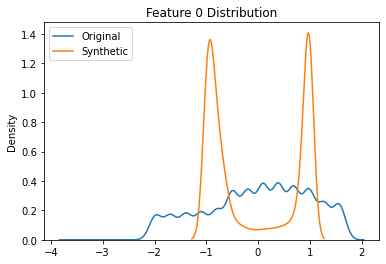

C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


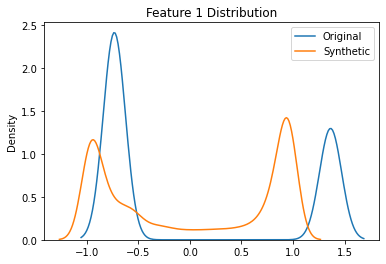

C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


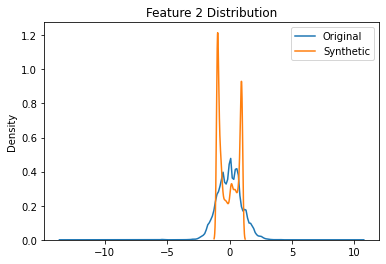

C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


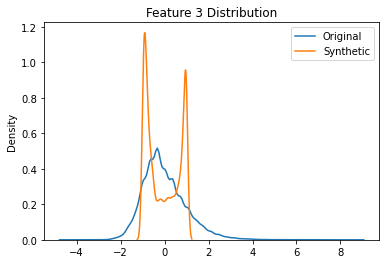

C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


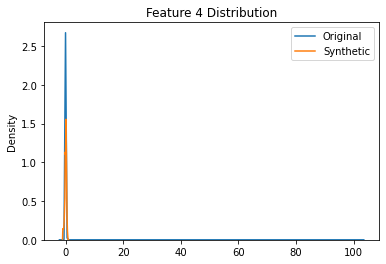

C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


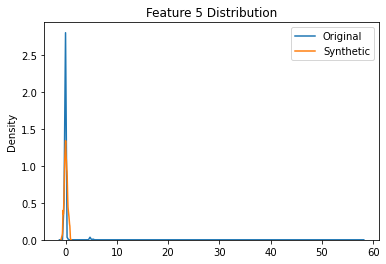

C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


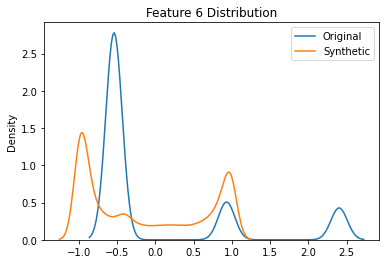

C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


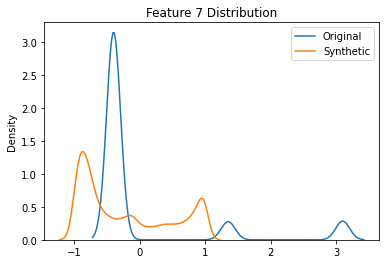

C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


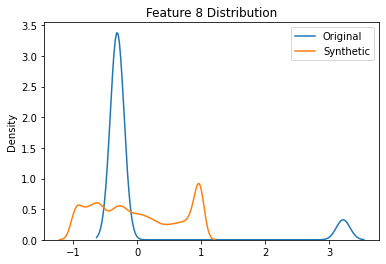

C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


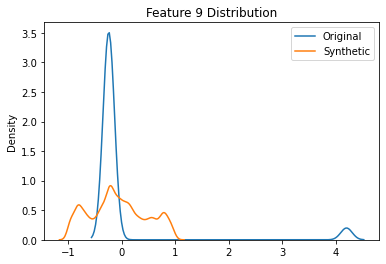

C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ede\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


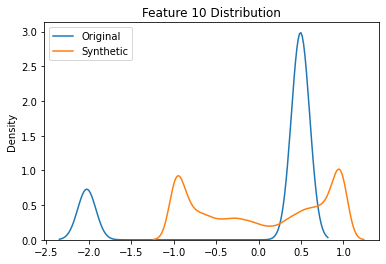

In [13]:
# Generate Synthetic Data:

# Define the number of synthetic samples to generate
number_of_samples = scaled_features.shape[0]  # for example, the same as your original dataset size

#Use the generator model to create synthetic data points.
# Ensure the amount of synthetic data is sufficient for statistical comparison and machine learning tasks.

# Generate noise input for the generator
noise = np.random.normal(0, 1, (number_of_samples, latent_dim))

# Use the generator to create synthetic data
synthetic_data = generator.predict(noise)

# Statistical Comparison:

# Compare key statistical properties (mean, variance, distribution, etc.) between the synthetic data and the original data.
# Visualization tools (like histograms, scatter plots) and statistical tests (like KS-test) can be useful here.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example: Compare distributions
for i in range(scaled_features.shape[1]):
    sns.distplot(scaled_features[:, i], label='Original', hist=False)
    sns.distplot(synthetic_data[:, i], label='Synthetic', hist=False)
    plt.title(f'Feature {i} Distribution')
    plt.legend()
    plt.show()

# Utility Assessment

In [14]:
from sklearn.model_selection import train_test_split

# Assuming 'features' and 'labels' are your dataset's features and target variable
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(features, labels, test_size=0.3, random_state=42)

In [17]:
import lightgbm as lgb
from sklearn.metrics import classification_report

# Create and train the LightGBM model
lgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05)
lgbm_model.fit(X_train_real, y_train_real)

# Predict and evaluate
y_pred_lgbm = lgbm_model.predict(X_test_real)
print(classification_report(y_test_real, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 24440, number of negative: 24560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498776 -> initscore=-0.004898
[LightGBM] [Info] Start training from score -0.004898
              precision    recall  f1-score   support

           0       0.72      0.78      0.75     10461
           1       0.76      0.69      0.73     10539

    accuracy                           0.74     21000
   macro avg       0.74      0.74      0.74     21000
weighted avg       0.74      0.74      0.74     21000



In [18]:
from xgboost import XGBClassifier

# XGBoost model
xgb_model = XGBClassifier(n_estimators=2000, learning_rate=0.005)
xgb_model.fit(X_train_real, y_train_real)
y_pred_xgb = xgb_model.predict(X_test_real)
print(classification_report(y_test_real, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.72      0.78      0.75     10461
           1       0.76      0.70      0.73     10539

    accuracy                           0.74     21000
   macro avg       0.74      0.74      0.74     21000
weighted avg       0.74      0.74      0.74     21000



In [80]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

# CatBoost model
cat_model = CatBoostClassifier(iterations=100, learning_rate=0.05, depth=10, verbose=False)
cat_model.fit(X_train_real, y_train_real)

# Predict and evaluate
y_pred_cat = cat_model.predict(X_test_real)
print(classification_report(y_test_real, y_pred_cat))



              precision    recall  f1-score   support

           0       0.72      0.78      0.75     10461
           1       0.76      0.70      0.73     10539

    accuracy                           0.74     21000
   macro avg       0.74      0.74      0.74     21000
weighted avg       0.74      0.74      0.74     21000



0    35021
1    34979
dtype: int64


In [54]:
!pip install xgboost


In [61]:
!pip install lightgbm


In [65]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Define the parameter grid
param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [10, 15, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}

# Create the model
lgbm = lgb.LGBMClassifier()

# Grid search
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_real, y_train_real)

# Best parameters
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 24440, number of negative: 24560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498776 -> initscore=-0.004898
[LightGBM] [Info] Start training from score -0.004898
Best parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100, 'num_leaves': 31}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_real)
X_test_scaled = scaler.transform(X_test_real)

# Convert labels to categorical
y_train_cat = to_categorical(y_train_real)
y_test_cat = to_categorical(y_test_real)

# Create the Keras model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Use softmax for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train_cat, epochs=1500, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test_cat)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.6419 - accuracy: 0.6482 - val_loss: 0.5941 - val_accuracy: 0.6904
Epoch 2/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5989 - accuracy: 0.6996 - val_loss: 0.5657 - val_accuracy: 0.7231
Epoch 3/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5839 - accuracy: 0.7133 - val_loss: 0.5584 - val_accuracy: 0.7289
Epoch 4/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5721 - accuracy: 0.7221 - val_loss: 0.5538 - val_accuracy: 0.7336
Epoch 5/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5686 - accuracy: 0.7223 - val_loss: 0.5494 - val_accuracy: 0.7305
Epoch 6/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5619 - accuracy: 0.7255 - val_loss: 0.5472 - val_accuracy: 0.7309
Epoch 7/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5591 - accuracy: 0.7254 - val_loss: 0.5474 -

Epoch 57/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5501 - accuracy: 0.7299 - val_loss: 0.5417 - val_accuracy: 0.7341
Epoch 58/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5530 - accuracy: 0.7299 - val_loss: 0.5433 - val_accuracy: 0.7349
Epoch 59/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5499 - accuracy: 0.7308 - val_loss: 0.5436 - val_accuracy: 0.7377
Epoch 60/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5500 - accuracy: 0.7310 - val_loss: 0.5421 - val_accuracy: 0.7378
Epoch 61/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5506 - accuracy: 0.7316 - val_loss: 0.5473 - val_accuracy: 0.7336
Epoch 62/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5496 - accuracy: 0.7297 - val_loss: 0.5449 - val_accuracy: 0.7364
Epoch 63/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5490 - accuracy: 0.7304 - val_loss: 0

1225/1225 [==============================] - 2s 2ms/step - loss: 0.5471 - accuracy: 0.7323 - val_loss: 0.5452 - val_accuracy: 0.7383
Epoch 168/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5497 - accuracy: 0.7323 - val_loss: 0.5448 - val_accuracy: 0.7357
Epoch 169/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5466 - accuracy: 0.7332 - val_loss: 0.5426 - val_accuracy: 0.7359
Epoch 170/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5470 - accuracy: 0.7323 - val_loss: 0.5425 - val_accuracy: 0.7359
Epoch 171/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5477 - accuracy: 0.7319 - val_loss: 0.5419 - val_accuracy: 0.7343
Epoch 172/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5468 - accuracy: 0.7329 - val_loss: 0.5425 - val_accuracy: 0.7356
Epoch 173/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5469 - accuracy: 0.7326 - val_loss: 0.5429 - 

1225/1225 [==============================] - 2s 2ms/step - loss: 0.5466 - accuracy: 0.7336 - val_loss: 0.5438 - val_accuracy: 0.7322
Epoch 278/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5457 - accuracy: 0.7322 - val_loss: 0.5447 - val_accuracy: 0.7354
Epoch 279/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5464 - accuracy: 0.7330 - val_loss: 0.5448 - val_accuracy: 0.7363
Epoch 280/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5444 - accuracy: 0.7332 - val_loss: 0.5466 - val_accuracy: 0.7348
Epoch 281/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5454 - accuracy: 0.7333 - val_loss: 0.5464 - val_accuracy: 0.7333
Epoch 282/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5459 - accuracy: 0.7342 - val_loss: 0.5462 - val_accuracy: 0.7352
Epoch 283/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5455 - accuracy: 0.7336 - val_loss: 0.5441 - 

1225/1225 [==============================] - 2s 2ms/step - loss: 0.5463 - accuracy: 0.7319 - val_loss: 0.5460 - val_accuracy: 0.7344
Epoch 388/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5494 - accuracy: 0.7347 - val_loss: 0.5455 - val_accuracy: 0.7343
Epoch 389/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5458 - accuracy: 0.7324 - val_loss: 0.5455 - val_accuracy: 0.7346
Epoch 390/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5430 - accuracy: 0.7337 - val_loss: 0.5440 - val_accuracy: 0.7342
Epoch 391/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5452 - accuracy: 0.7331 - val_loss: 0.5446 - val_accuracy: 0.7365
Epoch 392/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5475 - accuracy: 0.7333 - val_loss: 0.5455 - val_accuracy: 0.7353
Epoch 393/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5450 - accuracy: 0.7332 - val_loss: 0.5433 - 

1225/1225 [==============================] - 2s 2ms/step - loss: 0.5425 - accuracy: 0.7348 - val_loss: 0.5501 - val_accuracy: 0.7348
Epoch 498/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5439 - accuracy: 0.7327 - val_loss: 0.5472 - val_accuracy: 0.7348
Epoch 499/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5440 - accuracy: 0.7334 - val_loss: 0.5452 - val_accuracy: 0.7348
Epoch 500/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5451 - accuracy: 0.7324 - val_loss: 0.5449 - val_accuracy: 0.7345
Epoch 501/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5431 - accuracy: 0.7339 - val_loss: 0.5473 - val_accuracy: 0.7339
Epoch 502/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5445 - accuracy: 0.7320 - val_loss: 0.5450 - val_accuracy: 0.7357
Epoch 503/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5439 - accuracy: 0.7344 - val_loss: 0.5459 - 

1225/1225 [==============================] - 3s 2ms/step - loss: 0.5450 - accuracy: 0.7335 - val_loss: 0.5460 - val_accuracy: 0.7338
Epoch 608/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5443 - accuracy: 0.7324 - val_loss: 0.5479 - val_accuracy: 0.7330
Epoch 609/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5449 - accuracy: 0.7338 - val_loss: 0.5485 - val_accuracy: 0.7328
Epoch 610/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5437 - accuracy: 0.7336 - val_loss: 0.5455 - val_accuracy: 0.7310
Epoch 611/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5443 - accuracy: 0.7346 - val_loss: 0.5463 - val_accuracy: 0.7317
Epoch 612/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5428 - accuracy: 0.7347 - val_loss: 0.5469 - val_accuracy: 0.7356
Epoch 613/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5470 - accuracy: 0.7346 - val_loss: 0.5475 - 

1225/1225 [==============================] - 2s 2ms/step - loss: 0.5426 - accuracy: 0.7335 - val_loss: 0.5453 - val_accuracy: 0.7343
Epoch 718/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5435 - accuracy: 0.7331 - val_loss: 0.5472 - val_accuracy: 0.7333
Epoch 719/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5433 - accuracy: 0.7337 - val_loss: 0.5463 - val_accuracy: 0.7321
Epoch 720/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5446 - accuracy: 0.7345 - val_loss: 0.5457 - val_accuracy: 0.7339
Epoch 721/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5423 - accuracy: 0.7336 - val_loss: 0.5487 - val_accuracy: 0.7309
Epoch 722/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5480 - accuracy: 0.7325 - val_loss: 0.5471 - val_accuracy: 0.7315
Epoch 723/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5430 - accuracy: 0.7355 - val_loss: 0.5474 - 

1225/1225 [==============================] - 2s 2ms/step - loss: 0.5470 - accuracy: 0.7333 - val_loss: 0.5483 - val_accuracy: 0.7311
Epoch 828/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5425 - accuracy: 0.7355 - val_loss: 0.5483 - val_accuracy: 0.7335
Epoch 829/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5428 - accuracy: 0.7349 - val_loss: 0.5501 - val_accuracy: 0.7330
Epoch 830/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5428 - accuracy: 0.7320 - val_loss: 0.5501 - val_accuracy: 0.7316
Epoch 831/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5443 - accuracy: 0.7332 - val_loss: 0.5481 - val_accuracy: 0.7336
Epoch 832/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5436 - accuracy: 0.7340 - val_loss: 0.5491 - val_accuracy: 0.7318
Epoch 833/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5428 - accuracy: 0.7333 - val_loss: 0.5495 - 

1225/1225 [==============================] - 2s 2ms/step - loss: 0.5405 - accuracy: 0.7346 - val_loss: 0.5501 - val_accuracy: 0.7308
Epoch 938/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5422 - accuracy: 0.7354 - val_loss: 0.5511 - val_accuracy: 0.7324
Epoch 939/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5433 - accuracy: 0.7323 - val_loss: 0.5532 - val_accuracy: 0.7342
Epoch 940/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5437 - accuracy: 0.7346 - val_loss: 0.5528 - val_accuracy: 0.7315
Epoch 941/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5506 - accuracy: 0.7345 - val_loss: 0.5543 - val_accuracy: 0.7311
Epoch 942/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5453 - accuracy: 0.7327 - val_loss: 0.5541 - val_accuracy: 0.7329
Epoch 943/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5598 - accuracy: 0.7329 - val_loss: 0.5517 - 

1225/1225 [==============================] - 2s 2ms/step - loss: 0.5434 - accuracy: 0.7336 - val_loss: 0.5523 - val_accuracy: 0.7314
Epoch 1048/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5436 - accuracy: 0.7330 - val_loss: 0.5534 - val_accuracy: 0.7331
Epoch 1049/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5447 - accuracy: 0.7346 - val_loss: 0.5510 - val_accuracy: 0.7320
Epoch 1050/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5408 - accuracy: 0.7351 - val_loss: 0.5519 - val_accuracy: 0.7328
Epoch 1051/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5427 - accuracy: 0.7352 - val_loss: 0.5511 - val_accuracy: 0.7322
Epoch 1052/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5412 - accuracy: 0.7330 - val_loss: 0.5521 - val_accuracy: 0.7309
Epoch 1053/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5651 - accuracy: 0.7333 - val_loss: 0.5

1225/1225 [==============================] - 3s 3ms/step - loss: 0.5453 - accuracy: 0.7346 - val_loss: 0.5520 - val_accuracy: 0.7315
Epoch 1103/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5437 - accuracy: 0.7323 - val_loss: 0.5522 - val_accuracy: 0.7299
Epoch 1104/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5454 - accuracy: 0.7333 - val_loss: 0.5532 - val_accuracy: 0.7298
Epoch 1105/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5415 - accuracy: 0.7355 - val_loss: 0.5529 - val_accuracy: 0.7302
Epoch 1106/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5482 - accuracy: 0.7324 - val_loss: 0.5528 - val_accuracy: 0.7297
Epoch 1107/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5421 - accuracy: 0.7348 - val_loss: 0.5533 - val_accuracy: 0.7300
Epoch 1108/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5427 - accuracy: 0.7344 - val_loss: 0.5

1225/1225 [==============================] - 3s 2ms/step - loss: 0.5424 - accuracy: 0.7353 - val_loss: 0.5534 - val_accuracy: 0.7301
Epoch 1158/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5419 - accuracy: 0.7341 - val_loss: 0.5522 - val_accuracy: 0.7313
Epoch 1159/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5431 - accuracy: 0.7337 - val_loss: 0.5522 - val_accuracy: 0.7314
Epoch 1160/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5426 - accuracy: 0.7336 - val_loss: 0.5509 - val_accuracy: 0.7300
Epoch 1161/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5598 - accuracy: 0.7356 - val_loss: 0.5534 - val_accuracy: 0.7303
Epoch 1162/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5517 - accuracy: 0.7339 - val_loss: 0.5554 - val_accuracy: 0.7292
Epoch 1163/1500
1225/1225 [==============================] - 2s 2ms/step - loss: 0.5440 - accuracy: 0.7344 - val_loss: 0.5

1225/1225 [==============================] - 3s 2ms/step - loss: 0.5414 - accuracy: 0.7339 - val_loss: 0.5575 - val_accuracy: 0.7283
Epoch 1213/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5423 - accuracy: 0.7362 - val_loss: 0.5527 - val_accuracy: 0.7316
Epoch 1214/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5439 - accuracy: 0.7340 - val_loss: 0.5538 - val_accuracy: 0.7310
Epoch 1215/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5427 - accuracy: 0.7324 - val_loss: 0.5556 - val_accuracy: 0.7293
Epoch 1216/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5425 - accuracy: 0.7337 - val_loss: 0.5527 - val_accuracy: 0.7327
Epoch 1217/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5418 - accuracy: 0.7352 - val_loss: 0.5557 - val_accuracy: 0.7290
Epoch 1218/1500
1225/1225 [==============================] - 3s 2ms/step - loss: 0.5494 - accuracy: 0.7333 - val_loss: 0.5

In [57]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Assuming 'features' and 'labels' are your dataset's features and target variable
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(features, labels, test_size=0.3, random_state=42)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_real)
X_test_poly = poly.transform(X_test_real)

# Feature selection with RFE
selector = RFE(RandomForestClassifier(), n_features_to_select=10, step=1)
X_train_selected = selector.fit_transform(X_train_poly, y_train_real)
X_test_selected = selector.transform(X_test_poly)


In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Create base classifiers with updated parameters
clf1 = LogisticRegression(max_iter=1000, solver='saga')
clf2 = RandomForestClassifier()  # Consider tuning hyperparameters
clf3 = SVC(probability=True)     # Consider tuning hyperparameters

# Voting classifier
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3)], voting='soft')
eclf.fit(X_train_scaled, y_train_real)

# Evaluate
print(classification_report(y_test_real, eclf.predict(X_test_scaled)))


C:\Users\Ede\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.72      0.76      0.74     10461
           1       0.75      0.71      0.73     10539

    accuracy                           0.73     21000
   macro avg       0.73      0.73      0.73     21000
weighted avg       0.73      0.73      0.73     21000



In [59]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Create base classifiers
clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = SVC(probability=True)

# Voting classifier
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3)], voting='soft')
eclf.fit(X_train_selected, y_train_real)

# Evaluate
print(classification_report(y_test_real, eclf.predict(X_test_selected)))


C:\Users\Ede\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.71      0.77      0.74     10461
           1       0.75      0.69      0.72     10539

    accuracy                           0.73     21000
   macro avg       0.73      0.73      0.73     21000
weighted avg       0.73      0.73      0.73     21000



In [58]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# XGBoost with GridSearchCV
model = XGBClassifier()
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_search.fit(X_train_selected, y_train_real)

# Best model
best_xgb = grid_search.best_estimator_

from sklearn.metrics import classification_report

# Evaluate the model
y_pred = best_xgb.predict(X_test_selected)
print(classification_report(y_test_real, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.78      0.75     10461
           1       0.76      0.70      0.73     10539

    accuracy                           0.74     21000
   macro avg       0.74      0.74      0.74     21000
weighted avg       0.74      0.74      0.74     21000



In [55]:
# 2. Implementing XGBoost with Cross-Validation
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score

# XGBoost model
model = XGBClassifier()

# Stratified K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(model, X_train_real, y_train_real, cv=kfold)

print("Cross-Validation Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# Fit and evaluate model
model.fit(X_train_real, y_train_real)
y_pred = model.predict(X_test_real)
print(classification_report(y_test_real, y_pred))

Cross-Validation Accuracy: 73.06% (0.58%)
              precision    recall  f1-score   support

           0       0.72      0.77      0.74     10461
           1       0.76      0.69      0.72     10539

    accuracy                           0.73     21000
   macro avg       0.74      0.73      0.73     21000
weighted avg       0.74      0.73      0.73     21000



In [48]:
from sklearn.model_selection import train_test_split

# Assuming 'features' and 'labels' are your dataset's features and target variable
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(features, labels, test_size=0.3, random_state=42)


from sklearn.ensemble import RandomForestClassifier

# Train a model to get feature importances
model = RandomForestClassifier()
model.fit(X_train_real, y_train_real)

# Get feature importances and select top features
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Select top N features
N = 5  # for example, top 5 features
X_train_real_selected = X_train_real.iloc[:, indices[:N]]
X_test_real_selected = X_test_real.iloc[:, indices[:N]]


In [50]:
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_real, y_train_real)  # Use the training data here

# Use the best model
best_model = grid_search.best_estimator_

In [51]:
from sklearn.metrics import classification_report

# Evaluate the model
y_pred = best_model.predict(X_test_real)  # Use the test data here
print(classification_report(y_test_real, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.79      0.75     10461
           1       0.77      0.69      0.73     10539

    accuracy                           0.74     21000
   macro avg       0.74      0.74      0.74     21000
weighted avg       0.74      0.74      0.74     21000



In [47]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split real data for evaluation
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(features, labels, test_size=0.3, random_state=42)

# Assuming the last column was dropped from synthetic data
# Drop the same column from X_test_real to match the feature count
X_test_real_modified = X_test_real.drop(X_test_real.columns[-1], axis=1)

# Train RandomForestClassifier on synthetic data
model = RandomForestClassifier()
model.fit(synthetic_data_features, y_train_synthetic_binary)  # Using binary labels

# Evaluate the model on modified real test data
y_pred = model.predict(X_test_real_modified)
print(classification_report(y_test_real, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10461
           1       0.50      1.00      0.67     10539

    accuracy                           0.50     21000
   macro avg       0.25      0.50      0.33     21000
weighted avg       0.25      0.50      0.34     21000



C:\Users\Ede\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [46]:
# Split real data
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming synthetic_data is your generated synthetic dataset
# Convert the continuous labels into binary format
y_train_synthetic_binary = (synthetic_data[:, -1] > 0.5).astype(int)

# Drop the last column from synthetic data to match the feature count
synthetic_data_features = synthetic_data[:, :-1]

# Split real data for evaluation
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train RandomForestClassifier on synthetic data
model = RandomForestClassifier()
model.fit(synthetic_data_features, y_train_synthetic_binary)  # Using binary labels

# Evaluate the model on real test data
y_pred = model.predict(X_test_real)
print(classification_report(y_test_real, y_pred))


C:\Users\Ede\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 11 features, but RandomForestClassifier is expecting 10 features as input.

In [33]:
# Step 4: Utility Assessment
# Split real data
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming synthetic_data is your generated synthetic dataset
# Convert the continuous labels into binary format
y_train_synthetic_binary = (synthetic_data[:, -1] > 0.5).astype(int)

# Split real data for evaluation
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train RandomForestClassifier on synthetic data
model = RandomForestClassifier()
model.fit(synthetic_data[:, :-1], y_train_synthetic_binary)  # Using binary labels

# Evaluate the model on real test data
y_pred = model.predict(X_test_real)
print(classification_report(y_test_real, y_pred))


C:\Users\Ede\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 11 features, but RandomForestClassifier is expecting 10 features as input.

In [23]:
# NEW
# After generating synthetic data
print("Synthetic data shape:", synthetic_data.shape)
print("Original data shape:", features.shape)

# Split synthetic data
X_train_synthetic = synthetic_data[:, :-1]  # Features
y_train_synthetic = synthetic_data[:, -1]   # Labels

# Print shapes for debugging
print("X_train_synthetic shape:", X_train_synthetic.shape)
print("y_train_synthetic shape:", y_train_synthetic.shape)
print("X_test_real shape:", X_test_real.shape)
print("y_test_real shape:", y_test_real.shape)

# Ensure feature count matches
if X_train_synthetic.shape[1] != X_test_real.shape[1]:
    raise ValueError("Feature count mismatch between synthetic training and real test data.")


Synthetic data shape: (70000, 11)
Original data shape: (70000, 11)
X_train_synthetic shape: (70000, 10)
y_train_synthetic shape: (70000,)
X_test_real shape: (21000, 11)
y_test_real shape: (21000,)


ValueError: Feature count mismatch between synthetic training and real test data.

In [25]:
# Assuming 'cardio' is the label column in your original dataset
X = cardio_df.drop('cardio', axis=1)  # Features
y = cardio_df['cardio']  # Labels

# Split original data
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Now check the shapes again
print("X_train_real shape:", X_train_real.shape)
print("X_test_real shape:", X_test_real.shape)


X_train_real shape: (49000, 11)
X_test_real shape: (21000, 11)


In [26]:
# Verify shape of synthetic_data
print("Synthetic data shape:", synthetic_data.shape)

# Correctly split synthetic data
X_train_synthetic = synthetic_data[:, :-1]  # All columns except the last one for features
y_train_synthetic = synthetic_data[:, -1]   # Last column for labels

# Check the shapes of the split synthetic data
print("X_train_synthetic shape:", X_train_synthetic.shape)
print("y_train_synthetic shape:", y_train_synthetic.shape)


Synthetic data shape: (70000, 11)
X_train_synthetic shape: (70000, 10)
y_train_synthetic shape: (70000,)


In [38]:
# Generate Synthetic Data
noise = np.random.normal(0, 1, (number_of_samples, latent_dim))
synthetic_data = generator.predict(noise)

# Ensure synthetic data has the same shape as real data
print("Shape of real data:", scaled_features.shape)
print("Shape of synthetic data:", synthetic_data.shape)

if synthetic_data.shape[1] != scaled_features.shape[1]:
    raise ValueError("Mismatch in feature count between synthetic and real data.")


2188/2188 [==============================] - 2s 902us/step
Shape of real data: (70000, 11)
Shape of synthetic data: (70000, 11)


In [39]:
# Step 1: Retrain the GAN
# Assuming generator, discriminator, and GAN have been defined as per previous steps

# Train GAN
train_gan(gan, generator, discriminator, scaled_features, epochs=1800, batch_size=32)  # Adjust epochs and batch_size as needed


1/1 [==============================] - 0s 19ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 0, D Loss: [0.65470332 0.6875    ], G Loss: 0.7423372268676758
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1, D Loss: [0.68686295 0.5625    ], G Loss: 0.7420216798782349
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 2, D Loss: [0.67187795 0.578125  ], G Loss: 0.7524374723434448
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 3, D Loss: [0.67628852 0.609375  ], G Loss: 0.7560558319091797
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 4, D Loss: [0.69505656 0.53125   ], G Loss: 0.7467207908630371
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data:

1/1 [==============================] - 0s 21ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 46, D Loss: [0.68801033 0.5625    ], G Loss: 0.7306787967681885
1/1 [==============================] - 0s 20ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 47, D Loss: [0.67463896 0.546875  ], G Loss: 0.7182128429412842
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 48, D Loss: [0.67389214 0.640625  ], G Loss: 0.7272218465805054
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 49, D Loss: [0.6748853 0.640625 ], G Loss: 0.7253451943397522
1/1 [==============================] - 0s 13ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 50, D Loss: [0.67496657 0.625     ], G Loss: 0.7155266404151917
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake da

1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 92, D Loss: [0.70289472 0.5       ], G Loss: 0.7443296313285828
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 93, D Loss: [0.69000629 0.5625    ], G Loss: 0.7240306735038757
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 94, D Loss: [0.68891346 0.5       ], G Loss: 0.7382303476333618
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 95, D Loss: [0.69089204 0.609375  ], G Loss: 0.7366548776626587
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 96, D Loss: [0.67250079 0.65625   ], G Loss: 0.7239459753036499
1/1 [==============================] - 0s 19ms/step
Shape of real data: (32, 11)
Shape of fake 

1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 182, D Loss: [0.67804879 0.578125  ], G Loss: 0.736484169960022
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 183, D Loss: [0.69101095 0.578125  ], G Loss: 0.7258976697921753
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 184, D Loss: [0.67504418 0.59375   ], G Loss: 0.727020263671875
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 185, D Loss: [0.6832529 0.609375 ], G Loss: 0.7273967266082764
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 186, D Loss: [0.68705693 0.578125  ], G Loss: 0.7263017296791077
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake

1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 272, D Loss: [0.66314059 0.75      ], G Loss: 0.7451033592224121
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 273, D Loss: [0.65565833 0.78125   ], G Loss: 0.7412155866622925
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 274, D Loss: [0.67183301 0.625     ], G Loss: 0.7698069214820862
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 275, D Loss: [0.68202403 0.59375   ], G Loss: 0.7542513608932495
1/1 [==============================] - 0s 20ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 276, D Loss: [0.66979289 0.734375  ], G Loss: 0.7611505389213562
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of 

1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 362, D Loss: [0.68903887 0.65625   ], G Loss: 0.7305246591567993
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 363, D Loss: [0.67633265 0.640625  ], G Loss: 0.7267947196960449
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 364, D Loss: [0.67626917 0.6875    ], G Loss: 0.7236220240592957
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 365, D Loss: [0.68025851 0.703125  ], G Loss: 0.7384345531463623
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 366, D Loss: [0.680718 0.59375 ], G Loss: 0.7390083074569702
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake

1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 452, D Loss: [0.69312343 0.453125  ], G Loss: 0.7304489612579346
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 453, D Loss: [0.69643641 0.5625    ], G Loss: 0.7487664222717285
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 454, D Loss: [0.69929853 0.484375  ], G Loss: 0.7172519564628601
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 455, D Loss: [0.67670882 0.59375   ], G Loss: 0.7309799194335938
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 456, D Loss: [0.67986953 0.625     ], G Loss: 0.7347608208656311
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of 

1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 542, D Loss: [0.67246613 0.609375  ], G Loss: 0.7561547756195068
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 543, D Loss: [0.70902756 0.453125  ], G Loss: 0.7439119815826416
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 544, D Loss: [0.68329138 0.671875  ], G Loss: 0.7478259801864624
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 545, D Loss: [0.65773398 0.734375  ], G Loss: 0.7574062943458557
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 546, D Loss: [0.68887642 0.578125  ], G Loss: 0.756264328956604
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of f

1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 632, D Loss: [0.68551242 0.59375   ], G Loss: 0.7142267227172852
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 633, D Loss: [0.68012115 0.59375   ], G Loss: 0.744497537612915
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 634, D Loss: [0.67557451 0.640625  ], G Loss: 0.7512772679328918
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 635, D Loss: [0.66258457 0.734375  ], G Loss: 0.7346384525299072
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 636, D Loss: [0.67489043 0.65625   ], G Loss: 0.7380517721176147
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of f

1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 722, D Loss: [0.6864149 0.5625   ], G Loss: 0.7454677224159241
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 723, D Loss: [0.67557979 0.703125  ], G Loss: 0.7516554594039917
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 724, D Loss: [0.66603372 0.796875  ], G Loss: 0.755742073059082
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 725, D Loss: [0.68153718 0.65625   ], G Loss: 0.7384942770004272
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 726, D Loss: [0.6742703 0.6875   ], G Loss: 0.7347590327262878
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake 

1/1 [==============================] - 0s 18ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 812, D Loss: [0.6832673 0.625    ], G Loss: 0.7426823377609253
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 813, D Loss: [0.6816808 0.578125 ], G Loss: 0.7300578355789185
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 814, D Loss: [0.67507109 0.609375  ], G Loss: 0.7304495573043823
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 815, D Loss: [0.68142217 0.59375   ], G Loss: 0.7248820066452026
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 816, D Loss: [0.68145338 0.625     ], G Loss: 0.7426666021347046
1/1 [==============================] - 0s 20ms/step
Shape of real data: (32, 11)
Shape of fake

1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 902, D Loss: [0.68364334 0.59375   ], G Loss: 0.7126010656356812
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 903, D Loss: [0.66539627 0.765625  ], G Loss: 0.7179173231124878
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 904, D Loss: [0.68064541 0.59375   ], G Loss: 0.7348113059997559
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 905, D Loss: [0.66567239 0.65625   ], G Loss: 0.703927755355835
1/1 [==============================] - 0s 20ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 906, D Loss: [0.68609142 0.625     ], G Loss: 0.7298486232757568
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of f

1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 992, D Loss: [0.66692993 0.671875  ], G Loss: 0.7324541211128235
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 993, D Loss: [0.67396757 0.734375  ], G Loss: 0.7294291257858276
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 994, D Loss: [0.68127176 0.65625   ], G Loss: 0.7380973100662231
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 995, D Loss: [0.66013315 0.71875   ], G Loss: 0.7393398284912109
1/1 [==============================] - 0s 13ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 996, D Loss: [0.66865444 0.8125    ], G Loss: 0.7298504114151001
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of 

1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1037, D Loss: [0.67609909 0.703125  ], G Loss: 0.7198002338409424
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1038, D Loss: [0.67946175 0.6875    ], G Loss: 0.7179055213928223
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1039, D Loss: [0.67384207 0.671875  ], G Loss: 0.7256350517272949
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1040, D Loss: [0.67279953 0.734375  ], G Loss: 0.7201340198516846
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1041, D Loss: [0.66333747 0.75      ], G Loss: 0.7244174480438232
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shap

1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1082, D Loss: [0.66378182 0.734375  ], G Loss: 0.7307251691818237
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1083, D Loss: [0.68778247 0.609375  ], G Loss: 0.7398451566696167
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1084, D Loss: [0.67994386 0.578125  ], G Loss: 0.7274630069732666
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1085, D Loss: [0.69319338 0.578125  ], G Loss: 0.7327605485916138
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1086, D Loss: [0.67416182 0.609375  ], G Loss: 0.7418868541717529
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shap

1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1127, D Loss: [0.66738361 0.6875    ], G Loss: 0.7121244072914124
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1128, D Loss: [0.681512 0.5625  ], G Loss: 0.7247675657272339
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1129, D Loss: [0.67722562 0.640625  ], G Loss: 0.7128602862358093
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1130, D Loss: [0.6748946 0.640625 ], G Loss: 0.7200930118560791
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1131, D Loss: [0.68370998 0.53125   ], G Loss: 0.6986410617828369
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of f

1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1172, D Loss: [0.66998619 0.578125  ], G Loss: 0.724077582359314
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1173, D Loss: [0.67868418 0.625     ], G Loss: 0.7200597524642944
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1174, D Loss: [0.67075786 0.515625  ], G Loss: 0.7287551164627075
1/1 [==============================] - 0s 13ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1175, D Loss: [0.67219603 0.671875  ], G Loss: 0.7035391926765442
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1176, D Loss: [0.67815399 0.609375  ], G Loss: 0.7157970666885376
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape

1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1217, D Loss: [0.6690118 0.578125 ], G Loss: 0.7316303849220276
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1218, D Loss: [0.66915652 0.65625   ], G Loss: 0.7164061665534973
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1219, D Loss: [0.67085046 0.625     ], G Loss: 0.718866229057312
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1220, D Loss: [0.67787668 0.59375   ], G Loss: 0.7255749702453613
1/1 [==============================] - 0s 18ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1221, D Loss: [0.69121936 0.484375  ], G Loss: 0.7303063869476318
1/1 [==============================] - 0s 13ms/step
Shape of real data: (32, 11)
Shape o

1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1262, D Loss: [0.66733947 0.640625  ], G Loss: 0.7431200742721558
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1263, D Loss: [0.66340467 0.671875  ], G Loss: 0.7401937246322632
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1264, D Loss: [0.66659921 0.6875    ], G Loss: 0.7405267953872681
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1265, D Loss: [0.67382798 0.640625  ], G Loss: 0.7420626282691956
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1266, D Loss: [0.68533459 0.578125  ], G Loss: 0.7404128313064575
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shap

1/1 [==============================] - 0s 18ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1307, D Loss: [0.68167183 0.65625   ], G Loss: 0.7291244268417358
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1308, D Loss: [0.67329681 0.703125  ], G Loss: 0.7287746071815491
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1309, D Loss: [0.67897338 0.6875    ], G Loss: 0.7183799743652344
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1310, D Loss: [0.67368713 0.59375   ], G Loss: 0.7276092767715454
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1311, D Loss: [0.67147362 0.6875    ], G Loss: 0.7261689901351929
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shap

1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1352, D Loss: [0.65174198 0.734375  ], G Loss: 0.7365188002586365
1/1 [==============================] - 0s 19ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1353, D Loss: [0.66659692 0.640625  ], G Loss: 0.7286320924758911
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1354, D Loss: [0.65351626 0.765625  ], G Loss: 0.7489825487136841
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1355, D Loss: [0.66393265 0.625     ], G Loss: 0.7428017854690552
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1356, D Loss: [0.66534758 0.765625  ], G Loss: 0.7301232814788818
1/1 [==============================] - 0s 12ms/step
Shape of real data: (32, 11)
Shap

1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1397, D Loss: [0.65842116 0.703125  ], G Loss: 0.7270967960357666
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1398, D Loss: [0.6763607 0.65625  ], G Loss: 0.7275550961494446
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1399, D Loss: [0.67205477 0.71875   ], G Loss: 0.7256041765213013
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1400, D Loss: [0.67488021 0.640625  ], G Loss: 0.7404466867446899
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1401, D Loss: [0.66004953 0.75      ], G Loss: 0.7364375591278076
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape 

1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1442, D Loss: [0.66592023 0.703125  ], G Loss: 0.7357648611068726
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1443, D Loss: [0.67142209 0.734375  ], G Loss: 0.746946394443512
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1444, D Loss: [0.67979032 0.640625  ], G Loss: 0.7236995100975037
1/1 [==============================] - 0s 19ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1445, D Loss: [0.68564099 0.71875   ], G Loss: 0.7410156726837158
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1446, D Loss: [0.67784107 0.625     ], G Loss: 0.755381166934967
1/1 [==============================] - 0s 18ms/step
Shape of real data: (32, 11)
Shape 

1/1 [==============================] - 0s 19ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1487, D Loss: [0.66064703 0.65625   ], G Loss: 0.7457314133644104
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1488, D Loss: [0.69102892 0.609375  ], G Loss: 0.7328945398330688
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1489, D Loss: [0.67683315 0.5625    ], G Loss: 0.7340874671936035
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1490, D Loss: [0.6802828 0.546875 ], G Loss: 0.7672877907752991
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1491, D Loss: [0.65829018 0.671875  ], G Loss: 0.7417032718658447
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape 

1/1 [==============================] - 0s 18ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1532, D Loss: [0.66309631 0.671875  ], G Loss: 0.7340943813323975
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1533, D Loss: [0.66617072 0.765625  ], G Loss: 0.7641342878341675
1/1 [==============================] - 0s 18ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1534, D Loss: [0.66317016 0.71875   ], G Loss: 0.7773795127868652
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1535, D Loss: [0.64681199 0.828125  ], G Loss: 0.7386850118637085
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1536, D Loss: [0.67732644 0.65625   ], G Loss: 0.7534421682357788
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shap

1/1 [==============================] - 0s 19ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1577, D Loss: [0.6543498 0.703125 ], G Loss: 0.7327451705932617
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1578, D Loss: [0.68225941 0.609375  ], G Loss: 0.7464129328727722
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1579, D Loss: [0.67903239 0.671875  ], G Loss: 0.7463006973266602
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1580, D Loss: [0.66492569 0.6875    ], G Loss: 0.737557590007782
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1581, D Loss: [0.6471906 0.75     ], G Loss: 0.7427453994750977
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of 

1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1622, D Loss: [0.65048164 0.65625   ], G Loss: 0.7349668741226196
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1623, D Loss: [0.68164143 0.640625  ], G Loss: 0.7212420105934143
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1624, D Loss: [0.64540011 0.796875  ], G Loss: 0.7210407257080078
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1625, D Loss: [0.63799509 0.65625   ], G Loss: 0.7433544397354126
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1626, D Loss: [0.65070182 0.625     ], G Loss: 0.7407057285308838
1/1 [==============================] - 0s 13ms/step
Shape of real data: (32, 11)
Shap

1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1667, D Loss: [0.67969778 0.609375  ], G Loss: 0.7224844098091125
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1668, D Loss: [0.68493867 0.578125  ], G Loss: 0.7384341955184937
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1669, D Loss: [0.66871989 0.59375   ], G Loss: 0.7294594049453735
1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1670, D Loss: [0.66732284 0.640625  ], G Loss: 0.7432713508605957
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1671, D Loss: [0.66372174 0.765625  ], G Loss: 0.7418745160102844
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shap

1/1 [==============================] - 0s 14ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1712, D Loss: [0.66900027 0.625     ], G Loss: 0.753663182258606
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1713, D Loss: [0.6810244 0.65625  ], G Loss: 0.7462422847747803
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1714, D Loss: [0.65793037 0.5625    ], G Loss: 0.7364280819892883
1/1 [==============================] - 0s 17ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1715, D Loss: [0.68686315 0.578125  ], G Loss: 0.7508543729782104
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1716, D Loss: [0.68128499 0.65625   ], G Loss: 0.7506228685379028
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape o

1/1 [==============================] - 0s 18ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1757, D Loss: [0.69999194 0.546875  ], G Loss: 0.7474337220191956
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1758, D Loss: [0.65767211 0.65625   ], G Loss: 0.7531254291534424
1/1 [==============================] - 0s 15ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1759, D Loss: [0.65590242 0.6875    ], G Loss: 0.7371035814285278
1/1 [==============================] - 0s 16ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1760, D Loss: [0.6403541 0.765625 ], G Loss: 0.7610052824020386
1/1 [==============================] - 0s 18ms/step
Shape of real data: (32, 11)
Shape of fake data: (32, 11)
Epoch: 1761, D Loss: [0.65910584 0.6875    ], G Loss: 0.7490066289901733
1/1 [==============================] - 0s 20ms/step
Shape of real data: (32, 11)
Shape 

In [40]:
# Step 2: Generate Synthetic Data
# Generate synthetic data
noise = np.random.normal(0, 1, (number_of_samples, latent_dim))
synthetic_data = generator.predict(noise)

2188/2188 [==============================] - 2s 887us/step


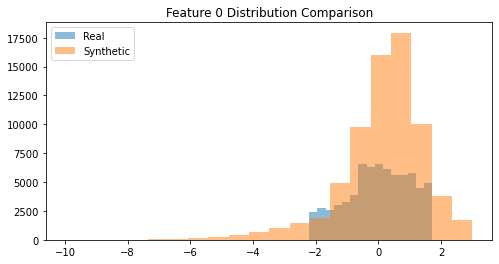

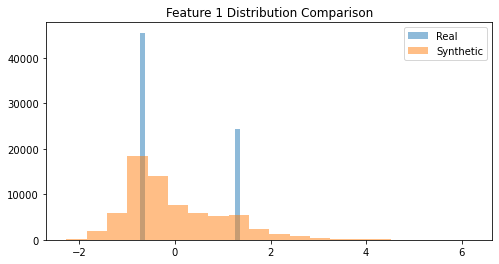

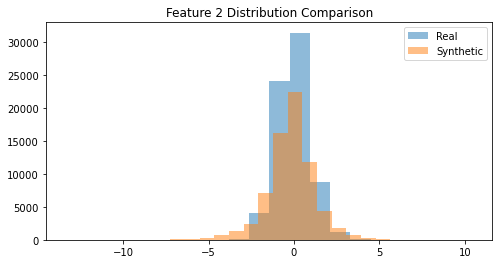

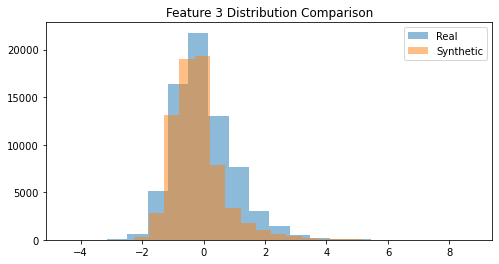

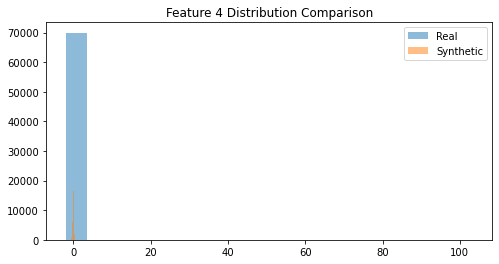

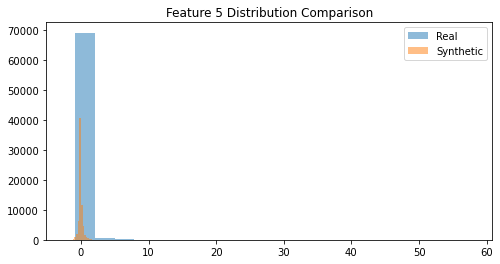

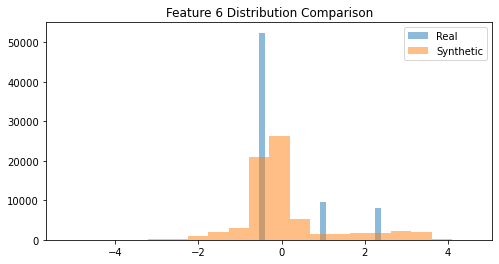

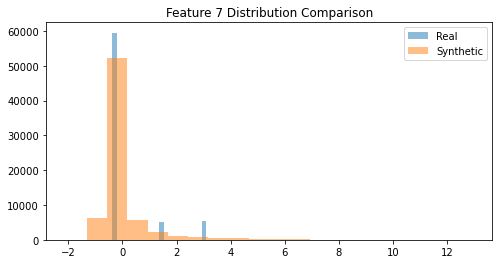

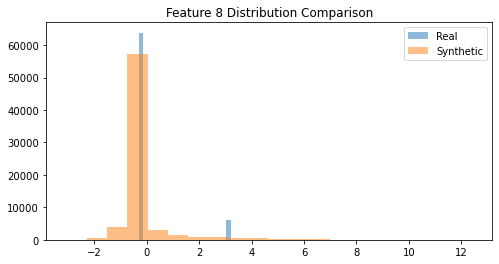

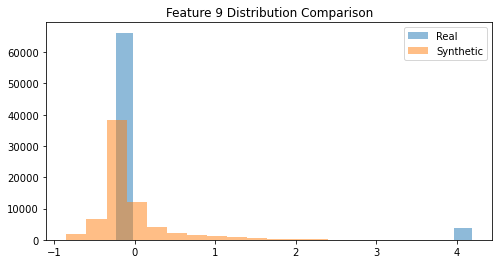

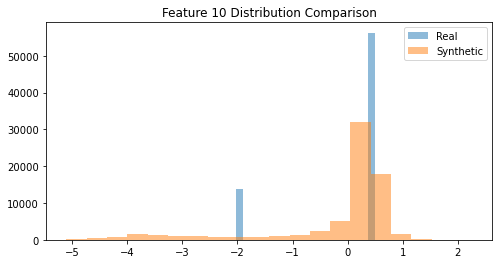

In [41]:
# Step 3: Quality Assessment of Synthetic Data
# Statistical comparison using histograms
for i in range(scaled_features.shape[1]):
    plt.figure(figsize=(8, 4))
    plt.hist(scaled_features[:, i], bins=20, alpha=0.5, label='Real')
    plt.hist(synthetic_data[:, i], bins=20, alpha=0.5, label='Synthetic')
    plt.title(f'Feature {i} Distribution Comparison')
    plt.legend()
    plt.show()


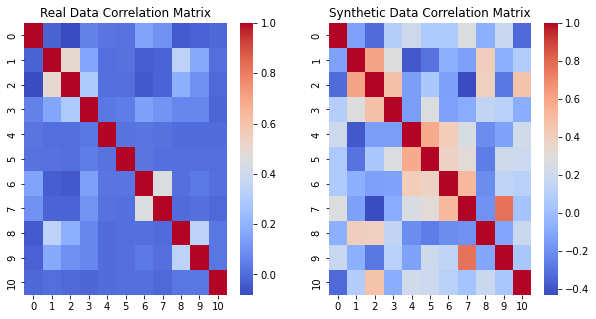

In [42]:
# Correlation Matrix Analysis
# Correlation matrix comparison
real_corr = np.corrcoef(scaled_features, rowvar=False)
synthetic_corr = np.corrcoef(synthetic_data, rowvar=False)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(real_corr, cmap='coolwarm')
plt.title('Real Data Correlation Matrix')

plt.subplot(1,2,2)
sns.heatmap(synthetic_corr, cmap='coolwarm')
plt.title('Synthetic Data Correlation Matrix')
plt.show()


In [48]:
# A. Generator
# The generator takes a point from the latent space and outputs synthetic data.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, LeakyReLU


def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Dense(11, activation='tanh'))  # Output size to match the 11 features
    return model

# latent_dim = 2  # or choose an appropriate size for the latent dimension
generator = build_generator(latent_dim)
generator.summary()


# Discriminator
# The discriminator should accept input data of the same shape as your dataset's features.
# The discriminator takes real or synthetic data and tries to classify it as real or fake.
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation='relu'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output
    return model

# Assuming build_discriminator is already defined
input_shape = (11,)  # Shape of the features in your dataset
discriminator = build_discriminator(input_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 128)               384       
                                                                 
 batch_normalization_12 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_13 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 64)              

In [49]:
# Generate new synthetic data with corrected generator
noise = np.random.normal(0, 1, (number_of_samples, latent_dim))
synthetic_data = generator.predict(noise)

# Split synthetic data
X_train_synthetic = synthetic_data[:, :-1]
y_train_synthetic = synthetic_data[:, -1]
y_train_synthetic_binary = (y_train_synthetic > 0.5).astype(int)


2188/2188 [==============================] - 2s 720us/step


In [50]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Check and print the shapes
print("Shape of synthetic training data:", X_train_synthetic.shape)
print("Shape of real test data:", X_test_real.shape)

# Train RandomForestClassifier on corrected synthetic data
model = RandomForestClassifier()
model.fit(X_train_synthetic, y_train_synthetic_binary)

# Evaluate on real test data
y_pred = model.predict(X_test_real)
print(classification_report(y_test_real, y_pred))


Shape of synthetic training data: (70000, 10)
Shape of real test data: (21000, 11)


C:\Users\Ede\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 11 features, but RandomForestClassifier is expecting 10 features as input.

In [47]:
# Check and print the shapes
print("Shape of synthetic training data:", X_train_synthetic.shape)
print("Shape of real test data:", X_test_real.shape)

# Ensure the number of features is the same
if X_train_synthetic.shape[1] != X_test_real.shape[1]:
    raise ValueError("Feature count mismatch between training and test data.")

# Train RandomForestClassifier on correct synthetic data
model = RandomForestClassifier()
model.fit(X_train_synthetic, y_train_synthetic_binary)

# Evaluate on real test data
y_pred = model.predict(X_test_real)
print(classification_report(y_test_real, y_pred))


Shape of synthetic training data: (70000, 10)
Shape of real test data: (21000, 11)


ValueError: Feature count mismatch between training and test data.

In [46]:
# Check the number of features in synthetic and real data
print("Synthetic data shape:", synthetic_data.shape)
print("Real data shape:", features.shape)

# If the shapes are not consistent, investigate the cause before proceeding

# Assuming synthetic_data now has the correct number of features
X_train_synthetic = synthetic_data[:, :-1]
y_train_synthetic_binary = (synthetic_data[:, -1] > 0.5).astype(int)

# Train RandomForestClassifier on synthetic data
model = RandomForestClassifier()
model.fit(X_train_synthetic, y_train_synthetic_binary)

# Evaluate the model on real test data
y_pred = model.predict(X_test_real)
print(classification_report(y_test_real, y_pred))


Synthetic data shape: (70000, 11)
Real data shape: (70000, 11)


C:\Users\Ede\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 11 features, but RandomForestClassifier is expecting 10 features as input.

In [11]:
# Extracting the target variable 'cardio' from the original dataset
labels = cardio_df['cardio'].values

# 1. Split Original Data for Training and Testing:

# Split the original dataset into training and testing sets to evaluate the utility of synthetic data.
# The testing set should only include real data to assess the model's performance on unseen, real instances.
from sklearn.model_selection import train_test_split
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    features, labels, test_size=0.3, random_state=42
)

# Before training the model, you can add a check to ensure the feature count is consistent:
print("Number of features in synthetic training data:", X_train_synthetic.shape[1])
print("Number of features in real test data:", X_test_real.shape[1])

if X_train_synthetic.shape[1] != X_test_real.shape[1]:
    raise ValueError("Mismatch in the number of features between synthetic training data and real test data.")

# 2. Train Models on Synthetic Data:

# Use the synthetic data to train various machine learning models.
# You can choose models like Decision Trees, Random Forests, MLP, Logistic Regression, etc.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assuming the last column of synthetic data is the label
X_train_synthetic = synthetic_data[:, :-1]  # All columns except the last one
y_train_synthetic = synthetic_data[:, -1]

# Convert continuous synthetic labels to binary format
y_train_synthetic_binary = (y_train_synthetic > 0.5).astype(int)

model = RandomForestClassifier()
model.fit(X_train_synthetic, y_train_synthetic_binary)

# 3. Evaluate Models on Real Test Data:

# Evaluate these models on the real test set.
# Use metrics like Accuracy, Precision, Recall, F1-Score, and AUC-ROC.
y_pred = model.predict(X_test_real)
print(classification_report(y_test_real, y_pred))

NameError: name 'X_train_synthetic' is not defined

In [12]:
# Assuming 'synthetic_data' is already generated and available

# Split synthetic data into features and labels
X_train_synthetic = synthetic_data[:, :-1]  # All columns except the last one
y_train_synthetic = synthetic_data[:, -1]
y_train_synthetic_binary = (y_train_synthetic > 0.5).astype(int)  # Convert continuous labels to binary

# Split Original Data for Training and Testing
from sklearn.model_selection import train_test_split

# Assuming 'features' and 'labels' are your original dataset's features and labels
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    features, labels, test_size=0.3, random_state=42
)

# Check Feature Consistency
print("Number of features in synthetic training data:", X_train_synthetic.shape[1])
print("Number of features in real test data:", X_test_real.shape[1])

if X_train_synthetic.shape[1] != X_test_real.shape[1]:
    raise ValueError("Mismatch in the number of features between synthetic training data and real test data.")

# Train Models on Synthetic Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier()
model.fit(X_train_synthetic, y_train_synthetic_binary)

# Evaluate Models on Real Test Data
y_pred = model.predict(X_test_real)
print(classification_report(y_test_real, y_pred))


Number of features in synthetic training data: 10
Number of features in real test data: 11


ValueError: Mismatch in the number of features between synthetic training data and real test data.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Lambda, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Load the Cardiovascular disease dataset
cardio_data_path = 'C:\\Users\\Ede\\Desktop\\Synthetic_Data_Using_AE_VAE_Techniques\\cardio.csv'
cardio_df = pd.read_csv(cardio_data_path)

# Process dataset: Feature extraction and scaling
features = cardio_df.drop('cardio', axis=1)  # Assuming 'cardio' is the target column
labels = cardio_df['cardio'].values

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    scaled_features, labels, test_size=0.3, random_state=42
)

# Displaying the first few rows of the dataset and summary information
cardio_df_info = cardio_df.info()
cardio_df_head = cardio_df.head()


# Define the VAE's sampling mechanism
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Define VAE architecture
def build_vae(input_shape, intermediate_dim=64, latent_dim=2):
    # Encoder
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(input_shape[0], activation='sigmoid')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')

    # VAE Model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')

    return vae, encoder, decoder

# Define GAN's Generator and Discriminator
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(11, activation='linear'))  # Output size to match the 11 features
    return model

def build_discriminator(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation='relu'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output
    return model

# Combine Generator and Discriminator to create GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    return model

# Train the GAN
def train_gan(gan, generator, discriminator, features, epochs, batch_size, latent_dim):
    for epoch in range(epochs):
        # Real data
        idx = np.random.randint(0, features.shape[0], batch_size)
        real_data = features[idx]
        real_labels = np.ones((batch_size, 1))

        # Fake data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_data = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, real_labels)

# Main Execution
scaled_features = ... # Your scaled feature data
labels = ... # Your target labels
input_shape = (scaled_features.shape[1],)
latent_dim = 2
epochs = 50

# VAE and GAN setup
vae, encoder, decoder = build_vae(input_shape)
generator = build_generator(latent_dim)
discriminator = build_discriminator(input_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Train GAN
train_gan(gan, generator, discriminator, scaled_features, epochs=1513, batch_size=32, latent_dim=latent_dim)

# Generate Synthetic Data
number_of_samples = scaled_features.shape[0]
noise = np.random.normal(0, 1, (number_of_samples, latent_dim))
synthetic_data = generator.predict(noise)

# Split synthetic data into features and labels
X_train_synthetic = synthetic_data
y_train_synthetic = (np.random.rand(number_of_samples) > 0.5).astype(int)  # Random binary labels

# Split real data for evaluation
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    scaled_features, labels, test_size=0.3, random_state=42)

# Check feature count match
if X_train_synthetic.shape[1] != X_test_real.shape[1]:
    raise ValueError("Feature count mismatch between synthetic training and real test data.")

# Train and evaluate model
model = RandomForestClassifier()
model.fit(X_train_synthetic, y_train_synthetic)
y_pred = model.predict(X_test_real)
print(classification_report(y_test_real, y_pred))

# Print the info and head of the dataframe to check the data
print(cardio_df_info)
print(cardio_df_head)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


AttributeError: 'ellipsis' object has no attribute 'shape'

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Lambda, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Load the Cardiovascular disease dataset
cardio_data_path = 'C:\\Users\\Ede\\Desktop\\Synthetic_Data_Using_AE_VAE_Techniques\\cardio.csv'
cardio_df = pd.read_csv(cardio_data_path)

# Process dataset: Feature extraction and scaling
features = cardio_df.drop('cardio', axis=1)  # Assuming 'cardio' is the target column
labels = cardio_df['cardio'].values

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    scaled_features, labels, test_size=0.3, random_state=42
)

# Displaying the first few rows of the dataset and summary information
cardio_df_info = cardio_df.info()
cardio_df_head = cardio_df.head()

# Define the VAE's sampling mechanism
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Define VAE architecture
def build_vae(input_shape, intermediate_dim=64, latent_dim=2):
    # Encoder
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(input_shape[0], activation='sigmoid')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')

    # VAE Model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')

    return vae, encoder, decoder

# Define GAN's Generator and Discriminator
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(11, activation='linear'))  # Output size to match the 11 features
    return model

def build_discriminator(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation='relu'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output
    return model

# Combine Generator and Discriminator to create GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    return model

# Train the GAN
def train_gan(gan, generator, discriminator, features, epochs, batch_size, latent_dim):
    for epoch in range(epochs):
        # Real data
        idx = np.random.randint(0, features.shape[0], batch_size)
        real_data = features[idx]
        real_labels = np.ones((batch_size, 1))

        # Fake data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_data = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, real_labels)

# Main Execution
input_shape = (scaled_features.shape[1],)
latent_dim = 2
epochs = 50

# VAE and GAN setup
vae, encoder, decoder = build_vae(input_shape)
generator = build_generator(latent_dim)
discriminator = build_discriminator(input_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Train GAN
train_gan(gan, generator, discriminator, scaled_features, epochs=1513, batch_size=32, latent_dim=latent_dim)

# Generate Synthetic Data
number_of_samples = scaled_features.shape[0]
noise = np.random.normal(0, 1, (number_of_samples, latent_dim))
synthetic_data = generator.predict(noise)

# Split synthetic data into features and labels
X_train_synthetic = synthetic_data
y_train_synthetic = (np.random.rand(number_of_samples) > 0.5).astype(int)  # Random binary labels

# Split real data for evaluation
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    scaled_features, labels, test_size=0.3, random_state=42)

# Check feature count match
if X_train_synthetic.shape[1] != X_test_real.shape[1]:
    raise ValueError("Feature count mismatch between synthetic training and real test data.")

# Train and evaluate model
model = RandomForestClassifier()
model.fit(X_train_synthetic, y_train_synthetic)
y_pred = model.predict(X_test_real)
print(classification_report(y_test_real, y_pred))

# Print the info and head of the dataframe to check the data
print(cardio_df_info)
print(cardio_df_head)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


2188/2188 [==============================] - 2s 840us/step
              precision    recall  f1-score   support

           0       0.48      0.44      0.46     10461
           1       0.49      0.52      0.50     10539

    accuracy                           0.48     21000
   macro avg       0.48      0.48      0.48     21000
weighted avg       0.48      0.48      0.48     21000

None
     age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2     168    62.0    110     80            1     1      0   
1  20228       1     156    85.0    140     90            3     1      0   
2  18857       1     165    64.0    130     70            3     1      0   
3  17623       2     169    82.0    150    100            1     1      0   
4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Lambda, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Load the Cardiovascular disease dataset
cardio_data_path = 'C:\\Users\\Ede\\Desktop\\Synthetic_Data_Using_AE_VAE_Techniques\\cardio.csv'
cardio_df = pd.read_csv(cardio_data_path)

# Process dataset: Feature extraction and scaling
features = cardio_df.drop('cardio', axis=1)  # Assuming 'cardio' is the target column
labels = cardio_df['cardio'].values

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    scaled_features, labels, test_size=0.3, random_state=42
)

# Displaying the first few rows of the dataset and summary information
cardio_df_info = cardio_df.info()
cardio_df_head = cardio_df.head()

# Define the VAE's sampling mechanism
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Define VAE architecture
def build_vae(input_shape, intermediate_dim=64, latent_dim=2):
    # Encoder
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(input_shape[0], activation='sigmoid')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')

    # VAE Model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')

    return vae, encoder, decoder

# Define GAN's Generator and Discriminator
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Dense(11, activation='tanh'))  # Output size to match the 11 features
    return model

def build_discriminator(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation='relu'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output
    return model

# Combine Generator and Discriminator to create GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    return model

# Train the GAN
def train_gan(gan, generator, discriminator, features, epochs, batch_size):
    for epoch in range(epochs):
        # Real data
        idx = np.random.randint(0, features.shape[0], batch_size)
        real_data = features[idx]
        real_labels = np.ones((batch_size, 1))

        # Fake data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_data = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, real_labels)

# Main Execution
input_shape = (scaled_features.shape[1],)
intermediate_dim = 64
batch_size = 128
latent_dim = 2
epochs = 50

# VAE and GAN setup
vae, encoder, decoder = build_vae(input_shape)
generator = build_generator(latent_dim)
discriminator = build_discriminator(input_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Train GAN
train_gan(gan, generator, discriminator, scaled_features, epochs=3500, batch_size=32)

# Generate Synthetic Data
number_of_samples = scaled_features.shape[0]
noise = np.random.normal(0, 1, (number_of_samples, latent_dim))
synthetic_data = generator.predict(noise)

# Split synthetic data into features and labels
X_train_synthetic = synthetic_data
y_train_synthetic = (np.random.rand(number_of_samples) > 0.5).astype(int)  # Random binary labels

# Split real data for evaluation
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    scaled_features, labels, test_size=0.3, random_state=42)

# Check feature count match
if X_train_synthetic.shape[1] != X_test_real.shape[1]:
    raise ValueError("Feature count mismatch between synthetic training and real test data.")

# Train and evaluate model
model = RandomForestClassifier()
model.fit(X_train_synthetic, y_train_synthetic)
y_pred = model.predict(X_test_real)
print(classification_report(y_test_real, y_pred))

# Print the info and head of the dataframe to check the data
print(cardio_df_info)
print(cardio_df_head)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step


2188/2188 [==============================] - 3s 1ms/step
              precision    recall  f1-score   support

           0       0.49      0.58      0.53     10461
           1       0.50      0.41      0.45     10539

    accuracy                           0.50     21000
   macro avg       0.50      0.50      0.49     21000
weighted avg       0.50      0.50      0.49     21000

None
     age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2     168    62.0    110     80            1     1      0   
1  20228       1     156    85.0    140     90            3     1      0   
2  18857       1     165    64.0    130     70            3     1      0   
3  17623       2     169    82.0    150    100            1     1      0   
4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0 